# Imports etc.

In [6]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy

In [106]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice'
fitted_param_plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'
plot_dir = "C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots"
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'

# Functions for simulating data

In [8]:
class WSLSAgent():
    
    def __init__(self, n_agents, params, model_name, p_right=0.5, eps=1e-5):
        self.n_agents = n_agents
        self.params = params
        self.beta = self.params['beta'].values
        self.bias = self.params['bias'].values
        self.p_right = p_right * np.ones((n_agents, 2))
        self.model_name = model_name
        self.avail_actions = (0, 1)
        self.prev_action = np.full(n_agents, np.nan)
        self.prev_reward = np.full(n_agents, np.nan)

    def p_from_prev_WSLS(self, action, reward):
        """
        Look up which action should be taken next, based on previous action(s) and outcome(s),
        using either the win-stay loose-shift (WSLS) strategy, or a 2-trial-back version of WSLS.
        """

        # Makes you choose right
        r1 = action * reward  # r1: right, reward
        l0 = (1 - action) * (1 - reward)  # l0: left, no reward
        l0l0 = (1 - self.prev_action) * (1 - self.prev_reward) * (1 - action) * (1 - reward)
        r1l0 = self.prev_action * self.prev_reward * (1 - action) * (1 - reward)
        r0l0 = self.prev_action * (1 - self.prev_reward) * (1 - action) * (1 - reward)
        r1r0 = self.prev_action * self.prev_reward * action * (1 - reward)

        # Makes you choose left
        r0 = action * (1 - reward)  # r0: right, no reward
        l1 = (1 - action) * reward  # l1: left, reward
        r0r0 = self.prev_action * (1 - self.prev_reward) * action * (1 - reward)
        l1r0 = (1 - self.prev_action) * self.prev_reward * action * (1 - reward)
        l0r0 = (1 - self.prev_action) * (1 - self.prev_reward) * action * (1 - action)
        l1l0 = (1 - self.prev_action) * self.prev_reward * (1 - action) * (1 - reward)

        if (self.model_name == 'WSLS') or (np.isnan(self.prev_action[0])):
            
#             ipdb.set_trace()
            self.p_right = scipy.special.softmax(-self.beta * np.array([
                r1 + l0 + self.bias,  # favoring right
                l1 + r0,  # favoring left
            ]).T, axis=1)

        else:

            self.p_right = scipy.special.softmax(-self.beta * np.array([
                r1 + l0l0 + r1l0 + r0l0 + r1r0 + self.bias,  # favoring right
                l1 + r0r0 + l1r0 + l0r0 + l1l0  # favoring left
            ]).T, axis=1)
            
        self.prev_action = action.copy()
        self.prev_reward = reward.copy()

        return self.p_right

    def take_action(self):
        """
        Take 1 action per agent, based on current trial likelihoods and priors.
        """
        
        action = np.array(
            [np.random.choice(self.avail_actions, p=self.p_right[a])
             for a in range(self.n_agents)])
        
        return self.p_right, action
        

# # Example use
# params = pd.DataFrame({
#     'beta': [4], 'bias': [0],
# })
# agent = WSLSAgent(n_agents, params, 'WSLS')

# # Simulate three trials
# lik, action = agent.take_action()
# print("Trial 1:", action)

# action = np.zeros(n_agents)
# reward = np.ones(n_agents)

# p_right = agent.p_from_prev_WSLS(action, reward)
# lik, action = agent.take_action()
# print("Trial 2:", action)

# action = np.zeros(n_agents)
# reward = np.zeros(n_agents)

# p_right = agent.p_from_prev_WSLS(action, reward)
# lik, action = agent.take_action()
# print("Trial 3:", action)

In [9]:
class RLAgent():
    
    def __init__(self, n_agents, params, forced_actions=[], init_Q=1/2, eps=1e-5):
        self.n_agents = n_agents
        self.params = params
        self.avail_actions = (0, 1)
        self.init_Q = init_Q
        self.Q = init_Q * np.ones((n_agents, len(self.avail_actions)))
        self.eps = eps
        self.prev_action = np.full(n_agents, np.nan)
        self.forced_actions = list(forced_actions)
        
    def take_action(self):
        """
        Take 1 action per agent, based on current trial Q-values.
        """
        
        ags = np.arange(self.n_agents)

        # Perseveration
        Q0 = self.Q[ags, 0]
        Q1 = self.Q[ags, 1]
        if not np.isnan(self.prev_action[0]):  # prev_action is np.nan on trial 0 only; only checking first element for simplicity
            Q0 += (1 - self.prev_action) * self.params['persev'].values  # action 0: subtract persev when repeating
            Q1 += self.prev_action * self.params['persev'].values   # action 1: add persev when repeating

        # Action selection
        lik = scipy.special.softmax(self.params['beta'].values * np.array([Q0, Q1]).T, axis=1)
        if self.forced_actions:
            action = self.forced_actions.pop(0) * np.ones(self.n_agents).astype(int)
        else:
            action = np.array([np.random.choice(self.avail_actions, p=lik[a]) for a in range(self.n_agents)])
        
        self.prev_action = action.copy()
        NLL = -np.log(lik[np.arange(self.n_agents), action])
        
        return NLL, action
    
    def update_Q(self, action, reward):
        """
        Update Q-values based on RL.
        """
        
        ags = np.arange(self.n_agents)
        
        rpe = (1 - self.Q[ags, action]) * reward  # received reward, updating chosen action
        nrpe = (0 - self.Q[ags, action]) * (1 - reward)  # received no reward, updating chosen action
        
        crpe = (0 - self.Q[ags, 1-action]) * reward  # received reward, updating unchosen action
        cnrpe = (1 - self.Q[ags, 1-action]) * (1 - reward)  # received no reard, updating unchosen action
        
        self.Q[ags, action] += self.params['alpha'].values * rpe + self.params['nalpha'].values * nrpe
        self.Q[ags, 1-action] += self.params['calpha'].values * crpe + self.params['cnalpha'].values * cnrpe

# Example use:
n_agents = 100
params = pd.DataFrame({
    'alpha': [0.8], 'nalpha': [0.1], 'calpha': [0.9], 'cnalpha': [0.1],
    'beta': [4], 'persev': [0.2], 'bias': [0]
})

agent = RLAgent(n_agents, params)
lik, action = agent.take_action()
print("action", action)
# correct, reward = task.present_reward(action, trial)
# print("reward", reward)
# agent.update_Q(action, reward)
# print("agent.Q", agent.Q)

action [0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1
 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0
 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0]


In [55]:
class BFAgent():
    
    def __init__(self, n_agents, params, forced_actions=[], p_r=0.5, eps=1e-5):
        self.n_agents = n_agents
        self.params = params
        self.p_reward = self.params['p_reward'].values
        self.p_switch = self.params['p_switch'].values
        self.beta = self.params['beta'].values
        self.persev = self.params['persev'].values
        self.bias = self.params['bias'].values
        self.p_r = p_r * np.ones(n_agents)  # Bayesian posterior probability of selecting right (propagated through trials)
        self.p_right = p_r * np.ones((n_agents, 2))  # behavioral probability of selecting right (log-transformed and with perseverance bonus)
        self.p_noisy = eps
        self.avail_actions = (0, 1)
        self.prev_action = np.full(n_agents, np.nan)
        self.forced_actions = list(forced_actions)

    def take_action(self):
        """
        Take 1 action per agent, based on current trial likelihoods and priors.
        """
        
        if np.isnan(self.beta):  # Basic Bayesian model, no free parameters
            self.p_right = np.array([1 - self.p_r, self.p_r]).T  # self.p_r is the actual probability; self.p_right is after adding perseverance etc.

        if self.forced_actions:
            action = self.forced_actions.pop(0) * np.ones(self.n_agents).astype(int)
        else:
            action = np.array(
                [np.random.choice(self.avail_actions, p=self.p_right[a])
                 for a in range(self.n_agents)]).astype(int)
        self.prev_action = action.copy()
        
        NLL = -np.log(self.p_right[np.arange(self.n_agents), action])
        
        return NLL, action
        
    def get_likelihoods(self, action, reward):
        
        # p(r=r|choice=correct): Likelihood of outcome (reward 0 or 1) given choice was correct:
        #           |   reward==1   |   reward==0
        #           |---------------|-----------------
        # choice==1 | p_reward      | 1 - p_reward
        # choice==0 | p_noisy       | 1 - p_noisy

        lik_cor_rew1 = action * self.p_reward + (1 - action) * self.p_noisy
        lik_cor_rew0 = action * (1 - self.p_reward) + (1 - action) * (1 - self.p_noisy)
        self.lik_cor = reward * lik_cor_rew1 + (1 - reward) * lik_cor_rew0

        # p(r=r|choice=incorrect): Likelihood of outcome (reward 0 or 1) given choice was incorrect:
        #           |   reward==1   |   reward==0
        #           |---------------|-----------------
        # choice==1 | p_noisy       | 1 - p_noisy
        # choice==0 | p_reward      | 1 - p_reward

        lik_inc_rew1 = action * self.p_noisy + (1 - action) * self.p_reward
        lik_inc_rew0 = action * (1 - self.p_noisy) + (1 - action) * (1 - self.p_reward)
        self.lik_inc = reward * lik_inc_rew1 + (1 - reward) * lik_inc_rew0

        return self.lik_cor, self.lik_inc
        
    def update_priors(self, action, reward):
        
        # Apply Bayes rule: Posterior prob. that right action is correct, based on likelihood (i.e., received feedback)
        self.p_r = self.lik_cor * self.p_r / (self.lik_cor * self.p_r + self.lik_inc * (1 - self.p_r))

        # Take into account that a switch might occur
        self.p_r = (1 - self.p_switch) * self.p_r + self.p_switch * (1 - self.p_r)
        
        # Add perseverance bonus
        if not np.isnan(self.prev_action[0]):  # prev_action is np.nan on trial 0 only; only checking first element for simplicity
            persev_bonus = 2 * self.prev_action - 1  # -1 for choice==0 (left) and +1 for choice==1 (right)
            scaled_persev_bonus = persev_bonus * self.persev
            p_right0 = self.p_r + scaled_persev_bonus
        else:
            p_right0 = self.p_r.copy()

        # Log-transform probabilities
        self.p_right = scipy.special.softmax(-self.beta * np.array([p_right0 + self.bias, (1 - p_right0)]).T, axis=1)
#         self.p_right = 0.0001 + 0.9998 * self.p_right  # make 0.0001 < p_right < 0.9999

        # p_r is the actual probability of right, which is the prior for the next trial
        # p_right is p_r after adding perseveration and log-transform, used to select actions
        return self.p_r, self.p_right, p_right0
        
# Example use
params = pd.DataFrame({
    'p_reward': [0.75], 'p_switch': [0.05], 'beta': [np.nan], 'persev': [0], 'bias': [0],
})
n_agents = 3
agent = BFAgent(n_agents, params)

lik, action = agent.take_action()

action = np.ones(n_agents)
reward = np.ones(n_agents)

lik_cor, lik_inc = agent.get_likelihoods(action=action, reward=reward)
lik_cor, lik_inc

p_r, p_right, p_right0 = agent.update_priors(action=action, reward=reward)
p_r, p_right, p_right0

lik, action = agent.take_action()
action

array([1, 1, 1])

In [30]:
class PSTask():
    
    def __init__(self, correct_actions, p_cor=0.75,
                 forced_rewards=[],
                 n_trials=[], block_lengths_lower=[], block_lengths_upper=[]):
        """
        Must either provide block_lengths_lower and block_lengths_upper -> task will be created on the fly;
        or correct_actions -> provided task will be used.
        """
        
        self.p_cor = p_cor
        self.forced_rewards = list(forced_rewards)

        if len(correct_actions) > 0:
            self.correct_actions = correct_actions
            self.n_trials = len(correct_actions)
        elif block_lengths_lower: 
            self.block_lengths_lower = block_lengths_lower
            self.block_lengths_upper = block_lengths_upper
            self.n_trials = n_trials
            self.correct_actions = self.make_task()
        else:
            raise ValueError("You must provide either correct_actions or block_lengths_lower.")
        
    def make_task(self):
        """
        Currently just produces the same sequence of correct and incorrect boxes for each animal.
        In future, will read in animal data.
        """
        
        correct_actions = []
        block_lengths = np.random.randint(
            low=self.block_lengths_lower, high=self.block_lengths_upper, size=self.n_trials)

        for block_length, correct_side in zip(block_lengths, [0, 1] * self.n_trials):
            correct_actions += block_length * [correct_side]
        
        correct_actions = correct_actions[:self.n_trials]
        
        return correct_actions
        
    def get_chance_rewards(self, n_correct_choices):
        """
        Translate accuracy into rewards:
        Return '1' with probability self.p_cor and '0' with probability 1-self.p_cor, for each agent.
        """
        
        return np.array([np.random.choice((0, 1), p=(1-self.p_cor, self.p_cor)) for i in range(n_correct_choices)])

    def present_reward(self, action, trial):
        """
        Present reward (0, 1) for each agent in this trial, based on choices,
        by consulting the correct_box on the current trial.
        """
        
#         ipdb.set_trace()
        correct = np.array(self.correct_actions[trial] == action).astype(int)
        if self.forced_rewards:
            reward = self.forced_rewards.pop(0) * np.ones_like(correct)
        else:
            reward = correct.copy()
            reward[reward == 1] = self.get_chance_rewards(sum(reward==1))
        
        return correct, reward
    
# # Example use
# n_trials = 725
# block_lengths_lower = 40
# block_lengths_upper = 41
# n_agents = 10

# task = PSTask(
#     n_trials=n_trials, block_lengths_lower=block_lengths_lower, block_lengths_upper=block_lengths_upper,
#     correct_actions=[])
# task.make_task()

# task.get_chance_rewards(n_correct_choices=100)

# action = np.zeros(n_agents)
# trial = 0
# task.present_reward(action, trial)

In [33]:
def simulate_dataset(task_args, agent_args, model_class, n_trials, suff=''):
    
    actions = []
    liks = []
    rewards = []
    corrects = []

    # Get task and agent
    task = PSTask(correct_actions=task_args['correct_actions'], forced_rewards=task_args['forced_rewards'])
    if (model_class == 'BF') or (model_class == 'B'):
        agent = BFAgent(agent_args['n_agents'], agent_args['params'], agent_args['forced_actions'])
    elif (model_class == 'RL') or (model_class == 'R'):
        agent = RLAgent(agent_args['n_agents'], agent_args['params'], agent_args['forced_actions'])
    elif model_class == 'WSLS':
        agent = WSLSAgent(agent_args['n_agents'], agent_args['params'], agent_args['model_name'], agent_args['forced_actions'])

    # Play the game, save data
    for trial in range(n_trials):

        lik, action = agent.take_action()
        correct, reward = task.present_reward(action, trial)
        
        if (model_class == 'BF') or (model_class == 'B'):
            agent.get_likelihoods(action, reward)
            agent.update_priors(action, reward)
        elif (model_class == 'RL') or (model_class == 'R'):
            agent.update_Q(action, reward)
        elif model_class == 'WSLS':
            agent.p_from_prev_WSLS(action, reward)
            
        actions += [action]
        liks += [lik]
        rewards += [reward]
        corrects += [correct]

    # Format data
    data = pd.DataFrame(
            {'action' + suff: actions, 'lik' + suff: liks,
             'reward' + suff: rewards, 'correct' + suff: corrects, 'correct_action': task.correct_actions})
    data = data.reset_index()
    data = data.rename(columns={'index': 'trial'})

    data['mean_reward'] = np.mean(np.array(list(data['reward' + suff])), axis=1)
    data['mean_correct'] = np.mean(np.array(list(data['correct' + suff])), axis=1)
    data['block'] = np.append([0], np.cumsum(np.abs(np.diff(task.correct_actions))))

    return data

In [ ]:
# def simulate_dataset(task_args, agent_args, model_class, suff=''):
    
#     actions = []
#     liks = []
#     rewards = []
#     corrects = []

#     # Get task and agent
#     task = PSTask(task_args['p_cor'], n_trials=task_args['n_trials'],
#                   block_lengths_lower=task_args['block_lengths_lower'], block_lengths_upper=task_args['block_lengths_upper'],
#                   correct_actions=task_args['correct_actions'])
#     if model_class == 'BF':
#         agent = BFAgent(agent_args['n_agents'], agent_args['params'])
#     elif model_class == 'RL':
#         agent = RLAgent(agent_args['n_agents'], agent_args['params'])
#     elif model_class == 'WSLS':
#         agent = WSLSAgent(agent_args['n_agents'], agent_args['params'], agent_args['model_name'])

#     # Play the game, save data
#     for trial in range(n_trials):

#         lik, action = agent.take_action()
#         correct, reward = task.present_reward(action, trial)
        
#         if model_class == 'BF':
#             agent.get_likelihoods(action, reward)
#             agent.update_priors(action, reward)
#         elif model_class == 'RL':
#             agent.update_Q(action, reward)
#         elif model_class == 'WSLS':
#             agent.p_from_prev_WSLS(action, reward)
            
#         actions += [action]
#         liks += [lik]
#         rewards += [reward]
#         corrects += [correct]

#     # Format data
#     data = pd.DataFrame(
#             {'action' + suff: actions, 'lik' + suff: liks,
#              'reward' + suff: rewards, 'correct' + suff: corrects, 'correct_action': task.correct_actions})
#     data = data.reset_index()
#     data = data.rename(columns={'index': 'trial'})

#     data['mean_reward'] = np.mean(np.array(list(data['reward' + suff])), axis=1)
#     data['mean_correct'] = np.mean(np.array(list(data['correct' + suff])), axis=1)
#     data['block'] = np.append([0], np.cumsum(np.abs(np.diff(task.correct_actions))))

#     return data

# # Example use
# task_args = {
#     'p_cor': 0.75, 'correct_actions': [], 'n_trials': n_trials,
#     'block_lengths_lower': block_lengths_lower, 'block_lengths_upper': block_lengths_upper
# }
# agent_args = {
#     'n_agents': n_agents, 'params': params, 'model_name': 'WSLS',
# }

# data = simulate_dataset(task_args, agent_args, 'WSLS')
# data

In [92]:
(gg.ggplot(data, gg.aes('trial', 'mean_correct', color='block'))
 + gg.geom_point()
 + gg.geom_line()
)

NameError: name 'data' is not defined

# Making task structure figure

In [ ]:
task = PSTask(
    p_cor, n_trials=n_trials, block_lengths_lower=20, block_lengths_upper=30,
    correct_actions=[])
corrects = np.array(task.make_task())[:120].astype(float)
p_rew_left = 0.75 * corrects
p_rew_right = 0.75 * (1 - corrects)
structure = pd.DataFrame({'trial': np.arange(120), 'p_rew_left': p_rew_left, 'p_rew_right': p_rew_right})

In [ ]:
g = (gg.ggplot(structure, gg.aes('trial', 'p_rew_left'))
 + gg.geom_line(gg.aes(y='p_rew_left'), color='red')
 + gg.geom_line(gg.aes(y='p_rew_right'), color='blue')
 + gg.labs(x='Trial', y='p(reward)')
 + gg.coord_cartesian(ylim=(0, 1))
)
g.save('C:/Users/maria/Dropbox/Apps/Overleaf/ProbSwitchPaper/figures/task_structure.eps')
g.draw()

# Putting it all together

## Get true mouse data for IDs and action sequences

In [ ]:
fullID_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_AnimalID.csv')).T.values.flatten()
fullID_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_AnimalID.csv')).T.values.flatten()
fullIDs = np.concatenate([fullID_j, fullID_a])
animals = [int(str(fullID)[:-5]) for fullID in fullIDs]
ages = [int(str(fullID)[-5:-2]) for fullID in fullIDs]
true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))
true_dat

## Get fitted params

In [ ]:
fitted_params = pd.DataFrame()
modelnames = [f for f in os.listdir(fitted_param_dir) if ('.csv' in f) and ('params' in f)]
for modelname in modelnames:
    model_params = pd.read_csv(os.path.join(fitted_param_dir, modelname))
    model_params['model'] = modelname.split('_')[1]
    fitted_params = fitted_params.append(model_params, sort=False)
fitted_params

In [ ]:
np.unique(fitted_params.model)

### Plot fitted params

In [ ]:
fitted_params_ = fitted_params.copy()
fitted_params_['beta'] /= 20
fitted_params_long = fitted_params_.melt(
    id_vars=['sID', 'slope_variable', 'fullID', 'animal', 'PreciseYrs', 'Gender', 'treatment',
             'session', 'age_z', 'T1', 'PDS', 'model'],
    value_name='param_value', var_name='param'
)

In [ ]:
gg.options.figure_size = (8, 8)
g = (gg.ggplot(fitted_params_long, gg.aes('param', 'param_value'))
 + gg.stat_summary(geom='bar')
#  + gg.geom_point(position='jitter', alpha=0.1)
 + gg.facet_wrap('~ model')
 + gg.theme(axis_text_x=gg.element_text(rotation=45, hjust=1))
)
g.draw()
g.save(os.path.join(fitted_param_plot_dir, 'fitted_params.png'))

## Simulate all fitted models

In [ ]:
n_agents = 10
model_names = [modelname.split('_')[1] for modelname in modelnames]
# model_names = ['WSLS', 'WSLSS', 'WSLSd', 'WSLSSd']
print(model_names)

for model_name in model_names:
    print('Working on {}...'.format(model_name))
    sim_data = pd.DataFrame()
    
    if 'B' in model_name:
        param_names = ['beta', 'persev', 'p_switch', 'p_reward']
        model_class = 'BF'
    elif 'RL' in model_name:
        param_names = ['alpha', 'nalpha', 'calpha', 'cnalpha', 'beta', 'persev', 'bias']
        model_class = 'RL'
    elif 'WSLS' in model_name:
        param_names = ['beta', 'bias']
        model_class = 'WSLS'

    for animal, age, fullID in zip(animals, ages, fullIDs):
#         if (animal != 23) and (age != 43):  # Error in the Juvi_AnimalID.csv - rerunning fitted_params with fixed one

        # Get task for this mouse
        true_sub = true_dat.loc[(true_dat.age == age) & (true_dat.animal == animal)]
        n_trials = len(np.unique(true_sub.trial))
        correct_actions = true_sub.correct_action.values

        # Get params
        params = fitted_params.loc[
            (fitted_params.PreciseYrs == age) & (fitted_params.animal == animal) & (fitted_params.model == model_name),
            param_names]
        task_args = {
            'p_cor': 0.75, 'correct_actions': correct_actions, 'n_trials': 0,
            'block_lengths_lower': False, 'block_lengths_upper': False
        }
        agent_args = {
            'n_agents': n_agents, 'params': params, 'model_name': model_name,
        }

        sub_data = simulate_dataset(task_args, agent_args, model_class=model_class, suff='all')
        sub_data['session'] = true_sub.session
        sub_data['animal'] = animal
        sub_data['age'] = age
        sub_data['fullID'] = fullID
        sub_data['model'] = model_name

        sim_data = sim_data.append(sub_data)
    
    save_dir = os.path.join(fitted_param_dir, 'simulations/simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
    print("Saving sim_data ({}) to {}...".format(sim_data.shape, save_dir))
    sim_data.to_csv(save_dir, index=False)

### Basic check that simulated behavior looks reasonable

In [ ]:
gg.options.figure_size = (10, 10)
(gg.ggplot(sim_data, gg.aes('trial', 'mean_correct', color='gender'))
 + gg.stat_summary()
)

# Functions for calculating NLLs for datasets

In [79]:
def NLL_from_data_and_params(fitted_param_path, hum_data_path, model_name):
    
    """
    Take full human datasets (including correct actions, chosen actions, and received rewards) and fitted
    parameters (either RL or BF), and calculate the negative log-likelihood of the dataset given the parameters.
    """

    n_agents = 2
    n_trials = 120
    hum_file_names = [f for f in os.listdir(hum_data_path) if '.csv' in f]
    if model_name != 'B':
        fitted_parameters = pd.read_csv(os.path.join(fitted_param_path, "params_{}_age_z_291_pymc3.csv".format(model_name)))

    NLLs = []
    for file_name in hum_file_names:

        sID = int(file_name.split('_')[1].split('.')[0])
        hum_data = pd.read_csv(os.path.join(hum_data_path, "PS_{}.csv".format(sID)))
        correct_actions = hum_data.correct_box[:n_trials]
        actions = hum_data.selected_box[:n_trials]
        rewards = hum_data.reward[:n_trials]
        
        if model_name != 'B':
            subj_params = fitted_parameters[fitted_parameters['sID'] == sID]
        else:
            subj_params = np.array([1])
        if (len(subj_params) > 0) and (len(correct_actions) == n_trials):
            
            if 'RL' in model_name:
                params = pd.DataFrame({
                    'alpha': subj_params['alpha'], 'nalpha': subj_params['nalpha'],
                    'calpha': subj_params['calpha'], 'cnalpha': subj_params['cnalpha'],
                    'beta': subj_params['beta'], 'persev': subj_params['persev'], 'bias': [0]
                })
            elif model_name == 'B':
                params = pd.DataFrame({
                    'p_switch': [0.05], 'p_reward': [0.75],
                    'beta': [np.nan], 'persev': [0], 'bias': [0]
                })
            elif 'B' in model_name:
                params = pd.DataFrame({
                    'p_switch': subj_params['p_switch'], 'p_reward': subj_params['p_reward'],
                    'beta': subj_params['beta'], 'persev': subj_params['persev'], 'bias': [0]
                })
                
            task_args = {
                'correct_actions': correct_actions, 'forced_rewards': rewards,
            }
            agent_args = {
                'n_agents': n_agents, 'params': params, 'forced_actions': actions,
            }

            data = simulate_dataset(task_args, agent_args, model_name[:1], n_trials)

            NLL = np.sum(data['lik'].apply(lambda x : x[0]))
            NLLs += [[NLL, sID]]
            
    return pd.DataFrame(NLLs, columns=('NLL', 'sID'))

# # Example use
# hum_data_path = "C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/"
# fitted_param_path = "C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/new_ML_models/MCMC/clustermodels"

# NLLs = NLL_from_data_and_params(fitted_param_path, hum_data_path, 'B')
# NLLs

In [38]:
def make_groups(ages, colname, probs=(1, 3/4, 2/4, 1/4)):

    quantiles_f = np.quantile(ages.loc[(ages.sID < 300) * (ages.Gender=="Female"), colname], q=probs)
    quantiles_m = np.quantile(ages.loc[(ages.sID < 300) * (ages.Gender=="Male"), colname], q=probs)

    groups = np.full(len(ages), np.nan).astype(str)

    for i in range(len(probs)):
      groups[(ages.Gender=="Female") * (ages[colname] <= quantiles_f[i])] = "{}%".format(int(100*probs[i]))
      groups[(ages.Gender=="Male") * (ages[colname] <= quantiles_m[i])] = "{}%".format(int(100*probs[i]))

    groups[ages.sID >= 300] = "Adult"
    groups[ages.sID >= 400] = "UCB"

    return(groups)

# # Example use
# ages_file_dir = "C:/Users/maria/MEGAsync/SLCNdata/SLCNinfo2.csv"
# ages = pd.read_csv(ages_file_dir)
# ages = ages.rename({'ID': 'sID'}, axis=1)
# ages.Gender = ages.Gender.replace({2: 'Female', 1: 'Male'})
# ages['age_group'] = make_groups(ages, 'PreciseYrs')
# ages['age_group_'] = ages.age_group.replace({'25%': 9, '50%': 11.5, '75%': 14, '100%': 16.5, 'UCB': 21.5, 'Adult': 27.5}).astype(float)
# ages

## Putting it all together

In [109]:
ages_file_dir = "C:/Users/maria/MEGAsync/SLCNdata/SLCNinfo2.csv"
hum_data_path = "C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/"
fitted_param_path = "C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/new_ML_models/MCMC/clustermodels"

In [93]:
# Get ages file
ages = pd.read_csv(ages_file_dir)
ages = ages.rename({'ID': 'sID'}, axis=1)
ages.Gender = ages.Gender.replace({2: 'Female', 1: 'Male'})
ages['age_group'] = make_groups(ages, 'PreciseYrs')
ages['age_group_'] = ages.age_group.replace({'25%': 9, '50%': 11.5, '75%': 14, '100%': 16.5, 'UCB': 21.5, 'Adult': 27.5}).astype(float)
ages

# Calculate NLL for each participant, for each model
NLL_model_names = (
    'RLab', 'RLabc', 'RLabcp', 'RLabcpn', 'RLabcpnx', 'RLabnp2',
    'B', 'Bb', 'Bbp', 'Bbpr', 'Bbspr'
)

NLLs = pd.DataFrame({'sID': ages.sID, 'NLL': 0})
for model_name in NLL_model_names:
    print(model_name)
    NLL = NLL_from_data_and_params(fitted_param_path, hum_data_path, model_name)
    NLLs = NLLs.merge(NLL, on='sID', suffixes=("", "_{}".format(model_name)))

# Make NLLs pretty
NLLs = NLLs.drop('NLL', axis=1)
NLLs = NLLs.rename(columns={'NLL_{}'.format(n): n for n in NLL_model_names})
NLLs['RL_minus_BF'] = NLLs['RLabnp2'] - NLLs['Bbspr']
NLLs

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


RLab
RLabc
RLabcp
RLabcpn
RLabcpnx
RLabnp2
B
Bb
Bbp
Bbpr
Bbspr


,sID,RLab,RLabc,RLabcp,RLabcpn,RLabcpnx,RLabnp2,B,Bb,Bbp,Bbpr,Bbspr
0,12,38.466737,38.693523,34.690171,34.552657,36.691377,34.961251,62.936073,62.209248,61.868171,34.119180,34.338750
1,13,63.374392,63.753821,63.096901,62.562361,60.018680,58.508840,78.801586,66.463531,66.297518,65.671567,65.909910
2,15,48.926686,49.027724,25.218535,25.306481,24.715105,24.578796,58.070725,59.175810,47.088744,24.757752,24.730949
3,16,65.191823,65.273861,34.873013,32.314214,35.940959,34.867638,80.370511,69.164474,48.039609,36.903632,36.656907
4,17,74.798529,74.947513,72.808321,72.893998,68.312351,67.888986,103.547954,76.916922,75.799760,67.481496,67.438641
...,...,...,...,...,...,...,...,...,...,...,...,...
286,465,36.330458,31.552598,31.673977,31.673858,25.252428,25.165603,37.399503,39.845606,37.863304,25.879272,25.733043
287,466,26.690356,27.632687,24.902975,24.862126,19.908085,20.103031,29.826222,31.129257,29.448149,19.287304,19.119651
288,467,44.686600,44.894781,32.053309,31.891779,31.113125,31.149355,55.961993,58.453502,56.267461,32.208837,31.896714
289,468,37.750885,37.904314,38.068321,38.015959,40.016153,39.501866,45.654122,48.793509,45.422306,38.442192,38.595727


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\h_age_NLL_RL_BF.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


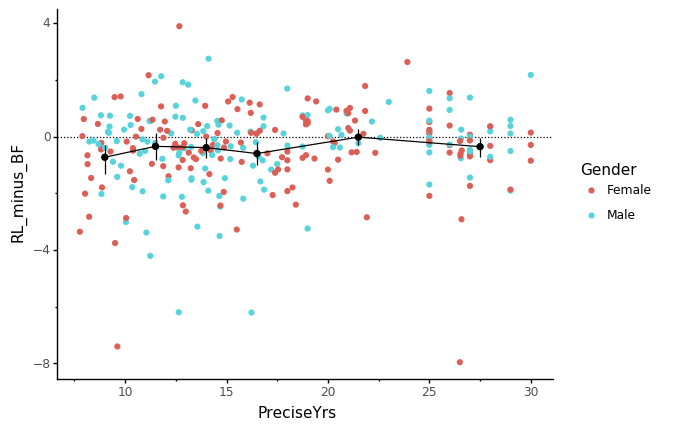

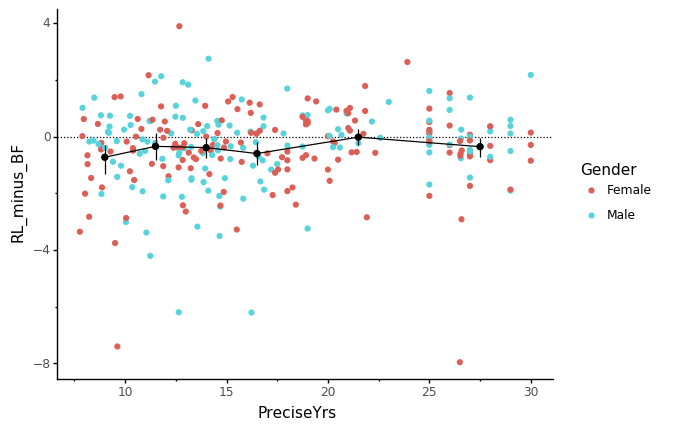

In [108]:
g = (gg.ggplot(NLLs.merge(ages), gg.aes('PreciseYrs', 'RL_minus_BF'))
 + gg.geom_hline(yintercept=0, linetype='dotted')
 + gg.geom_point(gg.aes(color='Gender'))
 + gg.stat_summary(gg.aes('age_group_'))
 + gg.stat_summary(gg.aes('age_group_'), geom='line')
)
g.save(os.path.join(plot_dir, "h_age_NLL_RL_BF.png"), width=4, height=4)
g.draw()

In [86]:
NLLs_l = pd.melt(NLLs,
                 value_vars=NLL_model_names,
                 id_vars=('sID'), var_name='model_name', value_name='NLL')
NLLs_l = NLLs_l.merge(ages)
NLLs_l

,sID,model_name,NLL,PDS,Category,Columbia_cat,BMI,Gender,Period_age,Last_period,Months,PreciseYrs,T1,T3,T4,meanT,age_group,age_group_
0,12,B,62.936073,NaN,NaN,NaN,NaN,Female,NaN,NaN,95.572895,7.964408,NaN,NaN,NaN,NaN,25%,9.0
1,12,Bb,62.209248,NaN,NaN,NaN,NaN,Female,NaN,NaN,95.572895,7.964408,NaN,NaN,NaN,NaN,25%,9.0
2,13,B,78.801586,NaN,NaN,NaN,NaN,Female,NaN,NaN,115.416838,9.618070,NaN,NaN,NaN,NaN,25%,9.0
3,13,Bb,66.463531,NaN,NaN,NaN,NaN,Female,NaN,NaN,115.416838,9.618070,NaN,NaN,NaN,NaN,25%,9.0
4,15,B,58.070725,NaN,NaN,NaN,NaN,Male,NaN,NaN,115.088296,9.590691,NaN,NaN,NaN,NaN,25%,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,467,Bb,58.453502,NaN,NaN,NaN,NaN,Female,NaN,NaN,NaN,18.750000,NaN,NaN,NaN,NaN,UCB,21.5
578,468,B,45.654122,NaN,NaN,NaN,NaN,Female,NaN,NaN,NaN,21.833333,NaN,NaN,NaN,NaN,UCB,21.5
579,468,Bb,48.793509,NaN,NaN,NaN,NaN,Female,NaN,NaN,NaN,21.833333,NaN,NaN,NaN,NaN,UCB,21.5
580,469,B,53.612546,NaN,NaN,NaN,NaN,Female,NaN,NaN,NaN,19.000000,NaN,NaN,NaN,NaN,UCB,21.5


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/Plots\h_age_NLL.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


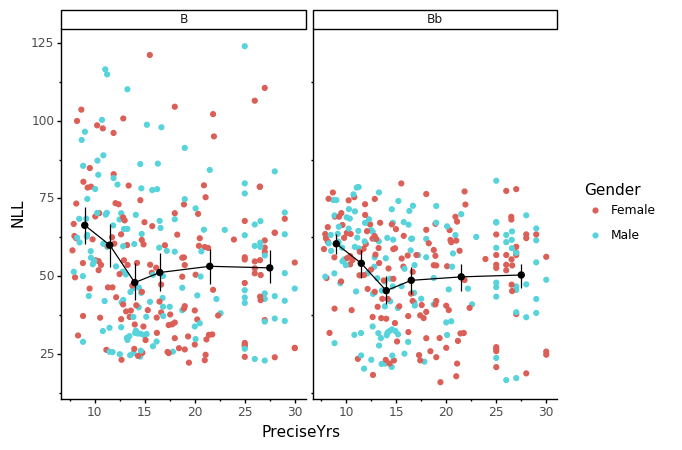

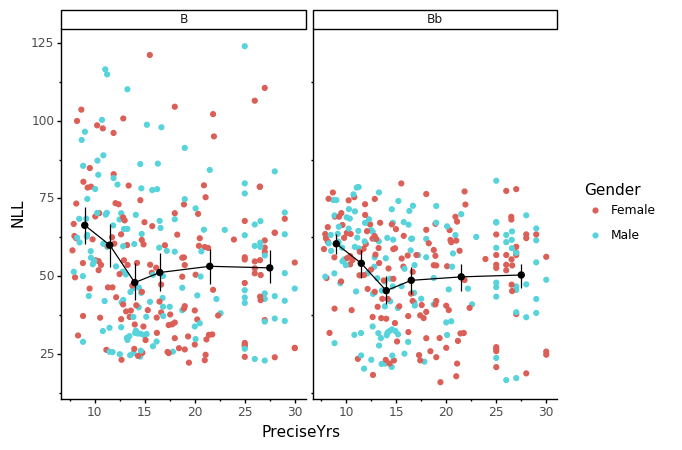

In [87]:
g = (gg.ggplot(NLLs_l, gg.aes(y='NLL'))
 + gg.geom_point(gg.aes('PreciseYrs', color='Gender'))
 + gg.stat_summary(gg.aes('age_group_'))
 + gg.stat_summary(gg.aes('age_group_'), geom="line")
 + gg.facet_wrap('~ model_name')
)
g.save(os.path.join(plot_dir, "h_age_NLL.png"), width=10, height=8)
g.draw()

## Calculate AIC for 0-param Bayes model

In [91]:
NLL = np.sum(NLLs.B)
n_params = 0
n_trials = 120

AIC = 2 * n_params + 2 * NLL
BIC = np.log(n_trials) * n_params + 2 * NLL
AIC, BIC

(31959.05676102976, 31959.05676102976)